# Check results from `Background` for multiple targets

In [63]:
import os
import re
import sys
import csv 
import shutil
import numpy as np
import pandas as pd
from datetime import date

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [76]:
# https://stackoverflow.com/questions/1868714/how-do-i-copy-an-entire-directory-of-files-into-an-existing-directory-using-pyth/22331852
from distutils.dir_util import copy_tree

In [2]:
sys.path.insert(0, "./results/python")
import background as bg

Old evaluation folder for this run detected
Do you want to resume evaluation?

Evaluating W1815
Number of parameters 6
OneHarvey
Run failed
Input not recognised, try input in  ['yes', 'y', 'Y', 'discard', 'd', 'D', 'retry', 'r', 'R', 'no', 'n']
Do you want to add any notes?

Evaluating W4110
Number of parameters 6
OneHarvey
Run failed
Input not recognised, try input in  ['yes', 'y', 'Y', 'discard', 'd', 'D', 'retry', 'r', 'R', 'no', 'n']
Do you want to add any notes?

Evaluating W508
Number of parameters 6
OneHarvey
Success!
[538.4210333  264.9807712   37.64816383 918.6704493   77.88195741
  15.16544923]
Good fit choosen
Fit is copied to ./evaluation/test_run00/goodfits
Do you want to add any notes?

Evaluating W3012
Number of parameters 6
OneHarvey
Run failed
Input not recognised, try input in  ['yes', 'y', 'Y', 'discard', 'd', 'D', 'retry', 'r', 'R', 'no', 'n']
Do you want to add any notes?

Evaluating W2202
Number of parameters 6
OneHarvey
Run failed
Input not recognised, try input 

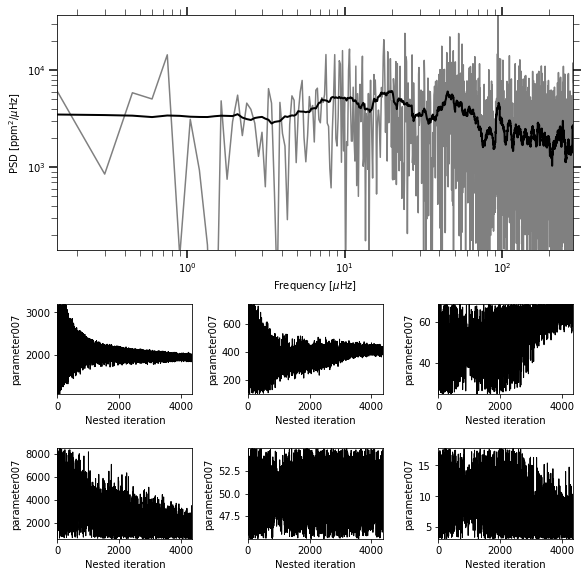

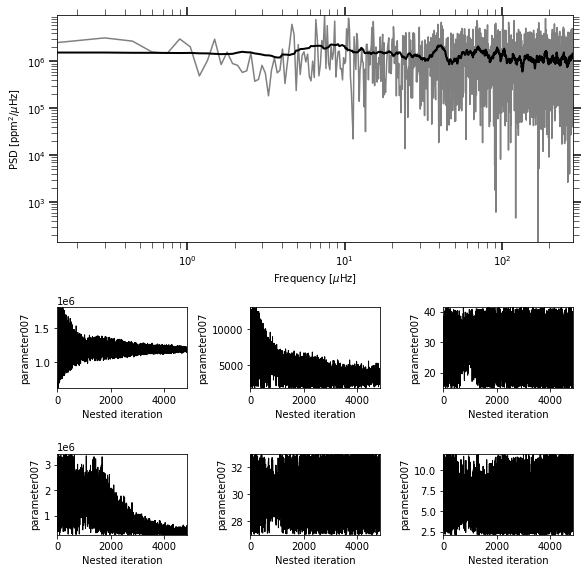

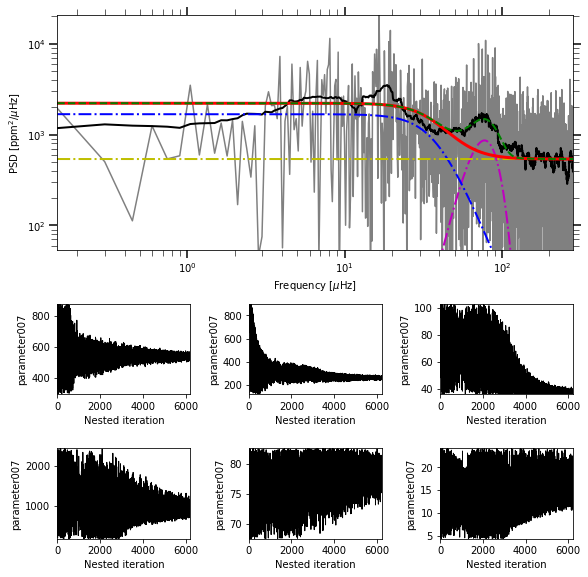

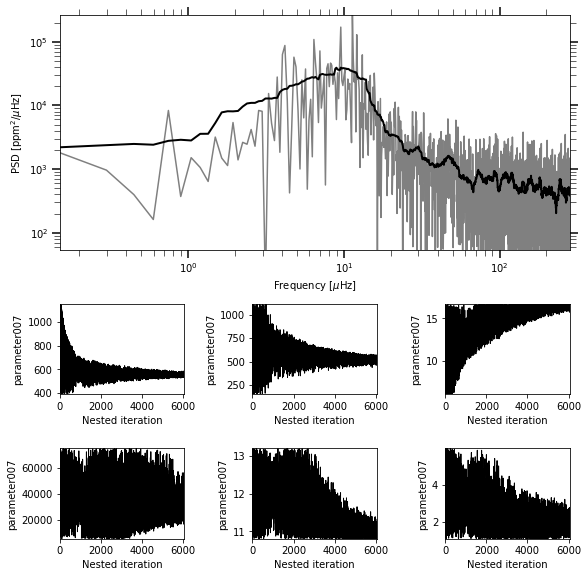

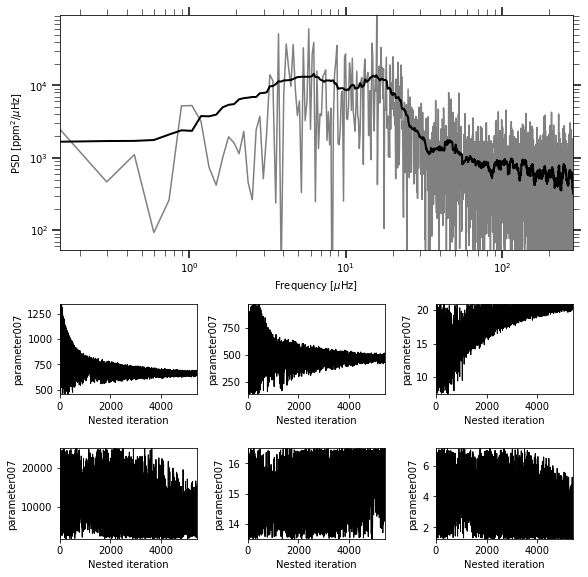

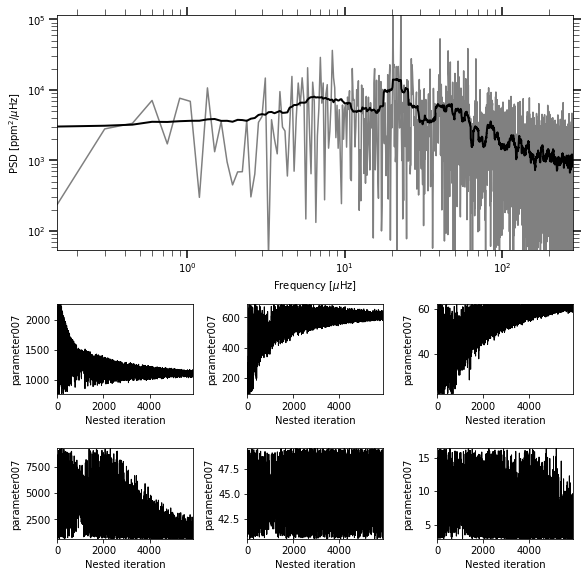

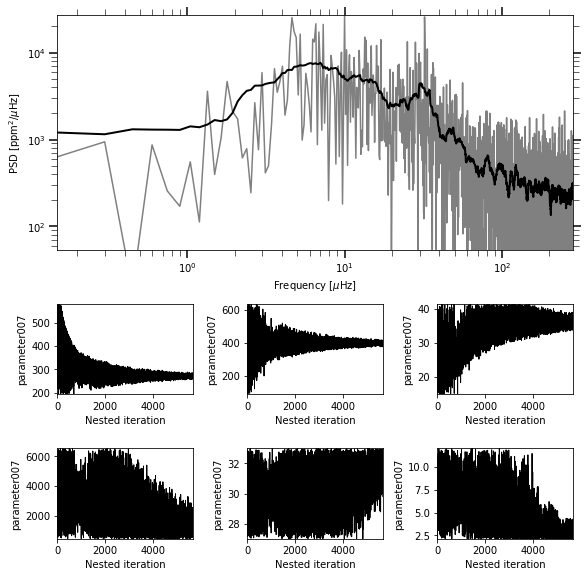

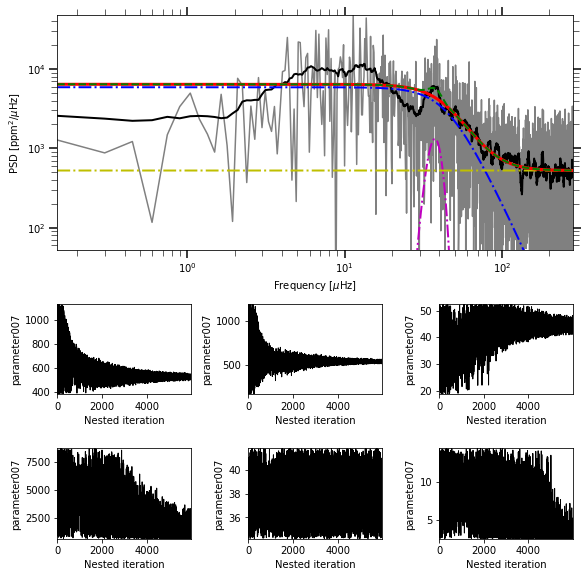

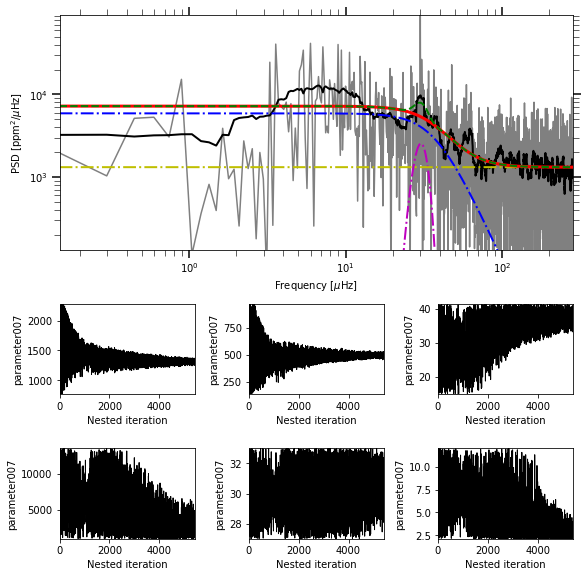

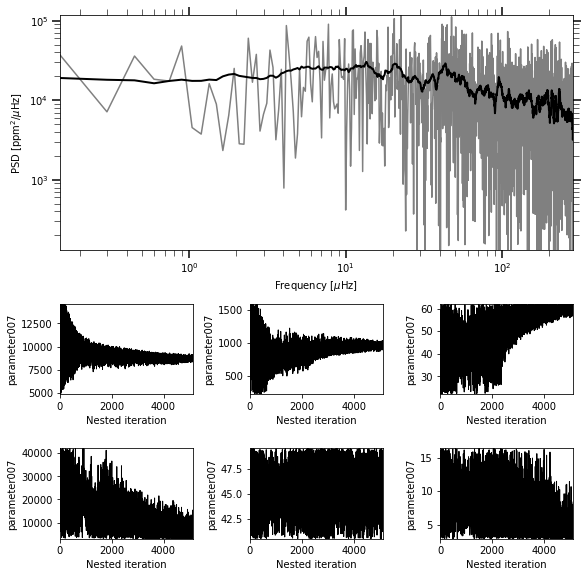

In [79]:
"""


"""

# TO-DO: PROMPT run idstr
run = '00'
idstr = 'test'

# Initialise
today = date.today().strftime('%Y%m%d')
datadir = './data/'

evaldir = './evaluation/'
runevaldir = os.path.join(evaldir, idstr + '_run' + run)
goodevaldir = os.path.join(runevaldir, 'goodfits')
discardlist = os.path.join(runevaldir, 'discardstars.txt')
logfile = today + '_' + idstr + 'run_' + run + '.csv'
fieldnames = ['date', 'star', 'decision', 'notes', 'model', 'params']

newrun = str(int(run)+1)
if len(newrun) < 2:
    newrun = '0' + newrun
retryshellscript = 'runBackground' + newrun + '.sh'
retrylist = []
modellist = []

backgroundmodels = ['FlatNoGaussian', 'Flat', 'Original',
                    'OneHarveyNoGaussian', 'TwoHarveyNoGaussian', 'ThreeHarveyNoGaussian',
                    'OneHarvey', 'TwoHarvey', 'ThreeHarvey',
                    'OneHarveyColor', 'TwoHarveyColor', 'ThreeHarveyColor']

# Define acceptable user input
goodinput = ['yes', 'y', 'Y',]
discardinput = ['discard', 'd', 'D']
retryinput = ['retry', 'r', 'R', 'no', 'n']

if not os.path.exists(evaldir):
    print('New evaluation directory created')
    os.mkdir(evaldir)
    
if not os.path.exists(runevaldir):
    print('New run evaluation directories created')
    os.mkdir(runevaldir)
    os.mkdir(goodevaldir)
    resume = False
else:
    print('Old evaluation folder for this run detected')
    print('Do you want to resume evaluation?')
    # TO-DO PROMPT userresume
    userresume = 'y'
    if userresume in goodinput:
        resume = True
    else:
        print('This will overwrite all earlier evaluations, are you sure?')
        # TO-DO PROMPT usersure
        usersure = 'n'
        if usersure in goodinput:
            resume = False
            os.rmdir(goodevaldir)
            os.mkdir(goodevaldir)
            if os.path.isfile(discardlist):
                os.remove(discardlist)
        else:
            print('Evaluation is resumed')
            resume = True

# Find all stars in datadir
starlist = []
for star in os.listdir(datadir):
    if star.endswith('.txt'):
        starlist.append(star.split('.')[0])
        
assert len(starlist) > 0

if resume:
    mode = 'a'
    if os.path.isfile(discardlist):
        discardstarlist = np.loadtxt(discardlist)
        for d in discardstarlist:
            print('Star is discarded', d)
            assert d in starlist
            starlist.remove(d)
    for g in os.listdir(goodevaldir):
        assert g in starlist
        starlist.remove(g)
else:
    mode = 'w'
    print('Iterating over all stars in', datadir)

# Make log
with open(logfile, mode, newline='') as log:
    writer = csv.DictWriter(log, fieldnames=fieldnames)
    if mode == 'w':
        writer.writeheader()

    # Loop over stars
        # On the same a4 page:
        # Does succes file exist?
            # If so:
                # Lightcurve with fit
            # Else:
                # Just lightcurve
        # Also: convergence plots

    for star in starlist[0:10]:
        print('')
        print('Evaluating', star)
        # Navigate to directory
        datafile = os.path.join('./data/' + star + '.txt')
        resultdir = os.path.join('./results/' + star)
        runresultdir = os.path.join(resultdir, run)
        summaryfile = os.path.join(runresultdir,
                                   'background_parameterSummary.txt')
        computationfile = os.path.join(runresultdir,
                                       'background_computationParameters.txt')

        # Count number of params
        paramfiles = [p for p in os.listdir(runresultdir) if 'parameter0' in p]

        # Human-sort list
        #https://stackoverflow.com/questions/4623446/how-do-you-sort-files-numerically
        paramfiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
        print('Number of parameters', len(paramfiles))

        # Make A4 figure
        pdffigure = os.path.join(runresultdir,
                                 'evaluationplot_' + star + '_' + run + '.pdf')
        
        with PdfPages(pdffigure) as pdf:
            fig = plt.figure(figsize=(8.27, 11.7)) # A4 format-ish
            ncols = 3
            gs = fig.add_gridspec(6, ncols)
            ax1 = fig.add_subplot(gs[0:2, :])

            # Here I adjusted code from `background_plot`
            freq, psd = np.loadtxt(datafile, unpack=True)
            config = np.loadtxt(computationfile, unpack=True, dtype=str)
            model_name = config[-2]
            print(model_name)

            # Plot best-fitting model or initial guess
            if os.path.isfile(summaryfile):
                print('Success!')
                params = np.loadtxt(summaryfile, usecols=(1,))
                print(params)
                numax = params[-2]
                bgf = bg.background_function(params, freq, model_name, star_dir=resultdir + '/')
                b1, b2, h_long, h_gran1, h_gran2, h_gran_original, g, w, h_color = bgf
            else:
                print('Run failed')
                params = None
                numax = 50

            dnu = 0.267 * numax ** 0.760
            freqbin = freq[1] - freq[0]
            width = dnu / freqbin
            win_len= int(width)
            if win_len % 2 == 0:
                win_len += 1
            psd_smth = bg.smooth(psd, window_len=win_len, window='flat')

            ax1.loglog(freq, psd, color='grey')
            ax1.set_xlim(np.min(freq), np.max(freq))
            ax1.set_ylim(np.min(w)*0.1, np.max(psd))
            ax1.set_xlabel(r'Frequency [$\mu$Hz]')
            ax1.set_ylabel(r'PSD [ppm$^2$/$\mu$Hz]')
            ax1.tick_params(width=1.5, length=8, top=True, right=True)
            ax1.tick_params(which='minor', length=6, top=True, right=True)

            ax1.plot(freq, psd_smth, 'k', lw=2)
            if params is not None:
                ax1.plot(freq, g, 'm-.', lw=2)
                ax1.plot(freq, h_color, 'y-.', lw=2)
                ax1.plot(freq, h_long, 'b-.', lw=2)
                ax1.plot(freq, h_gran1, 'b-.', lw=2)
                ax1.plot(freq, h_gran2, 'b-.', lw=2)
                ax1.plot(freq, h_gran_original, 'b-.', lw=2)
                ax1.plot(freq, w, 'y-.', lw=2)
                ax1.plot(freq, b1, 'r-', lw=3)
                ax1.plot(freq, b2, 'g--', lw=2)

            # Here I just copied the code from `parameter_evolution` but into a subplot
            for i, pf in enumerate(paramfiles):
                ax2 = fig.add_subplot(gs[2+ (i // ncols), i % ncols])
                sampling = np.loadtxt(os.path.join(runresultdir, pf), unpack=True)
                ax2.set_xlim(0, sampling.size)
                ax2.set_ylim(np.min(sampling),np.max(sampling))
                ax2.set_xlabel(r'Nested iteration')
                ax2.set_ylabel(p.split('_')[1].split('.')[0])
                ax2.plot(np.arange(sampling.size),sampling,'k', lw=1)
            plt.tight_layout()
            pdf.savefig(fig)

        # TO-DO Open pdf page with prompt
        # TO-DO PROMT usereval
        usereval = 'y'
        # usereval = 'n'
        # usereval = 'd'
        
        if params is not None and usereval in goodinput:
            print('Good fit choosen')
            print('Fit is copied to', goodevaldir)
            copy_tree(runresultdir, os.path.join(goodevaldir, star))
        elif usereval in retryinput:
            print('Retry fit choosen')
            newhyperparams = os.path.join(runresultdir,
                                          'background_hyperParameters_' + newrun + '.txt')
            # TO-DO PROMPT newmodel
            print('Would you like to keep the model?')
            # TO-DO usermodel
            if usermodel in goodinput:
                print('How would you like to update the parameters?')
                # TO-DO PROMPT rewrite hyperParameters
                hyperparamsfile = os.path.join(runresultdir,
                                               'background_hyperParameters_' + run + '.txt')
                hyperparams = np.loadtxt(hyper)
                # Read in hyperParameters_ + run + '.txt'
                # Show user
                # Change line for line
                # Save in hyperParameters_ + newrun + '.txt'
                print('New hyperparameters can be found in', newhyperparams)

            else:
                print('Which model would you like to change to?')
                # TO-DO PROMPT usermodel
                usermodel = 'OneHarvey'
                if usermodel not in backgroundmodels:
                    # TO-DO PROMPT Try again
                    usermodel = 'OneHarvey'
                
                prefix = re.split('(\d+)',star)[0]
                star_id = re.split('(\d+)',star)[1]
                
                print('What is your estimate of numax?')
                # TO-DO PROMPT numax
                usernumax = 50
                
                bg.set_background_priors(
                    catalog_id=prefix,
                    star_id=star_id,
                    numax=usernumax,
                    model_name=usermodel,
                    dir_flag=int(newrun))
                print('set_background_priors has made a new hyperparameter file')
            retrylist.append(star)
            modellist.append(usermodel)
        elif usereval in discardinput:
            print('Star is discarded')
            print('Star has been added to the discard list', discardlist)
            with open(discardlist, 'a') as dl:
                dl.write(star)
        else:
            print('Input not recognised, try input in ',
                  goodinput + discardinput + retryinput)
            # TO-DO PROMPT Try again
            
        # TO-DO PROMPT usernotes
        print('Do you want to add any notes?')
        usernotes = 'notes'
        
        writer.writerow({'date': date.today().strftime('%x%X'),
                         'star': star,
                         'decision': usereval,
                         'notes': usernotes,
                         'model': model_name,
                         'params': params})


if len(retrylist) > 0:
    with open(retryshellscript, "w") as f:
        print("#!/bin/bash", file=f)
        print("""
        f() {
                if ! ./background "$@" ; then
                        echo "[`date`] $@" >> %s
                fi
        }""" % errorfile, file=f)
        print('', file=f)
        for star, model in zip(retrylist, modellist):
            print(f"f {prefix} {star} {newrun} {model} background_hyperParameters 0.0 0",
                  file=f)

    print('A new shell script for rerunning fits has been made and is called', retryshellscript)
    print(f'In the terminal, make this file executable by running `chmod +x `{retryshellscript}`')
    print('Navigate to your `./build/` directory')
    print()
    print('and type')
    print(f'`../{retryshellscript}`')
    print('in the terminal and all the fits will run')
    print('If an error happens and a fit goes not go as intended,')
    print('the fit will be appended to the file `errors.txt`.')

print('Thanks for now -- bye!')